In [213]:
import pandas as pd 
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


In [214]:
#lecturas de archivos
contratos = pd.read_csv("final_provider/contract.csv")
internet = pd.read_csv("final_provider/internet.csv")
personal = pd.read_csv("final_provider/personal.csv")
phone = pd.read_csv("final_provider/phone.csv")


In [215]:
# Convertir fechas a datetime
contratos['BeginDate'] = pd.to_datetime(contratos['BeginDate'])
contratos['EndDate'] = contratos['EndDate'].replace('No', pd.NaT)
contratos['EndDate'] = pd.to_datetime(contratos['EndDate'])

# Convertir TotalCharges a numérico
contratos['TotalCharges'] = pd.to_numeric(contratos['TotalCharges'], errors='coerce')

#excluimos clientes que su contrato inicio despues del 1 dde febrero del 2020
contratos = contratos[contratos["BeginDate"] < "01/02/2020"]


In [216]:
df = contratos.merge(internet, on='customerID', how='left') \
              .merge(personal, on='customerID', how='left') \
              .merge(phone, on='customerID', how='left')


In [217]:
#Esto asignará 1 a los clientes que sí tienen fecha de finalización (cancelaron) y 0 a los que tienen 'No' (aún activos).
df['Churn'] = df['EndDate'].notna().astype(int)

In [218]:
#La fecha de referencia es el 1 de febrero de 2020. Vamos a crear una columna con la duración del contrato en meses.
fecha_corte = pd.to_datetime('2020-02-01')
df['SeniorityMonths'] = ((fecha_corte.year - df['BeginDate'].dt.year) * 12 +
                         (fecha_corte.month - df['BeginDate'].dt.month) +
                         (fecha_corte.day >= df['BeginDate'].dt.day).astype(int) - 1
                        )

In [219]:
# Vamos a contar cuántos servicios adicionales usa el cliente, Contar cuántos servicios son 'Yes'
servicios = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'MultipleLines'
]

df['ContratedServices'] = df[servicios].apply(lambda row: sum(row == 'Yes'), axis=1)

In [220]:
# eliminamos clientes inactivos (sin telefonia e internet)
inactivos = df[
    ((df['InternetService'] == 'No') | (df['InternetService'].isna())) &
    ((df['MultipleLines'] == 'No') | (df['MultipleLines'].isna()))
]

df = df.drop(inactivos.index).reset_index(drop=True)

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5852 entries, 0 to 5851
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customerID         5852 non-null   object        
 1   BeginDate          5852 non-null   datetime64[ns]
 2   EndDate            1766 non-null   datetime64[ns]
 3   Type               5852 non-null   object        
 4   PaperlessBilling   5852 non-null   object        
 5   PaymentMethod      5852 non-null   object        
 6   MonthlyCharges     5852 non-null   float64       
 7   TotalCharges       5852 non-null   float64       
 8   InternetService    5512 non-null   object        
 9   OnlineSecurity     5512 non-null   object        
 10  OnlineBackup       5512 non-null   object        
 11  DeviceProtection   5512 non-null   object        
 12  TechSupport        5512 non-null   object        
 13  StreamingTV        5512 non-null   object        
 14  Streamin

In [222]:
pd.set_option('display.max_columns', None)
df.sample(50)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,Churn,SeniorityMonths,ContratedServices
5604,4114-QMKVN,2015-06-01,NaT,One year,No,Bank transfer (automatic),68.75,3815.40,DSL,Yes,Yes,No,No,No,Yes,Female,0,Yes,Yes,Yes,0,56,4
504,9244-ZVAPM,2020-01-01,NaT,Month-to-month,No,Mailed check,45.60,45.60,DSL,No,No,No,No,No,No,Male,0,No,No,No,0,1,0
5632,5204-QZXPU,2018-05-01,2019-12-01,Month-to-month,Yes,Electronic check,39.65,733.35,DSL,No,No,Yes,No,Yes,No,Male,0,No,No,NaN,1,21,2
4950,6859-RKMZJ,2019-03-01,NaT,Month-to-month,Yes,Bank transfer (automatic),55.05,608.15,DSL,No,No,No,No,Yes,No,Male,0,Yes,No,No,0,11,1
3592,5599-HVLTW,2018-12-01,NaT,Month-to-month,Yes,Bank transfer (automatic),80.35,1058.10,Fiber optic,No,No,Yes,No,No,No,Female,1,No,No,Yes,0,14,2
5716,3191-CSNMG,2019-11-01,NaT,Month-to-month,Yes,Electronic check,80.70,239.45,Fiber optic,No,No,No,No,Yes,No,Female,0,Yes,Yes,No,0,3,1
362,2806-MLNTI,2015-10-01,NaT,One year,Yes,Bank transfer (automatic),105.10,5376.40,Fiber optic,No,Yes,Yes,No,Yes,Yes,Male,1,Yes,No,Yes,0,52,5
5174,5180-UCIIQ,2018-03-01,2020-01-01,Month-to-month,No,Mailed check,40.05,880.20,DSL,Yes,No,No,No,No,Yes,Male,1,Yes,Yes,NaN,1,23,2
3714,0667-NSRGI,2016-02-01,NaT,One year,Yes,Mailed check,69.55,3435.60,DSL,No,No,Yes,Yes,No,Yes,Female,0,Yes,No,Yes,0,48,4
1907,9578-VRMNM,2018-08-01,2019-12-01,Month-to-month,Yes,Credit card (automatic),65.20,1043.35,DSL,No,No,Yes,No,No,Yes,Female,0,No,No,Yes,1,18,3


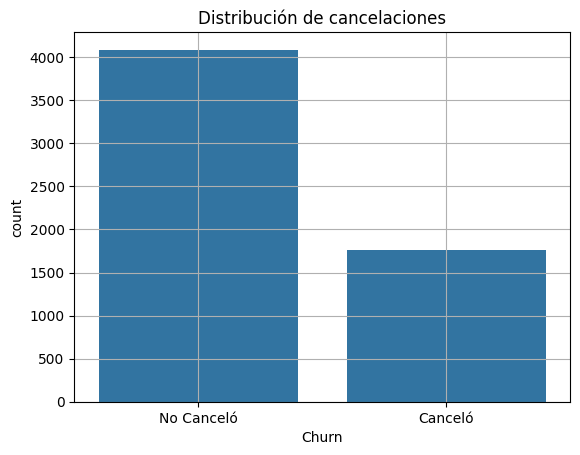

In [223]:
#distribucion general de la variable objetivo

sns.countplot(x='Churn', data=df)
plt.title('Distribución de cancelaciones')
plt.xticks([0,1], ['No Canceló', 'Canceló'])
plt.grid(True)
plt.show()

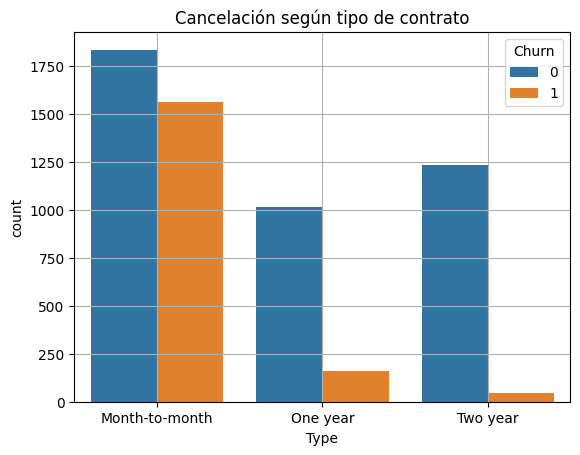

In [224]:
# cancelacion segun tipo de contrato
sns.countplot(x='Type', hue='Churn', data=df)
plt.title('Cancelación según tipo de contrato')
plt.grid(True)
plt.show()

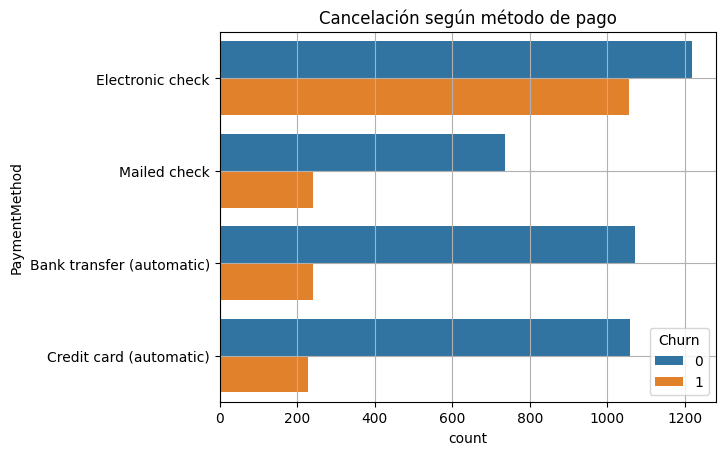

In [225]:
# cancelacion segun metodo de pago

sns.countplot(y='PaymentMethod', hue='Churn', data=df)
plt.title('Cancelación según método de pago')
plt.grid(True)
plt.show()

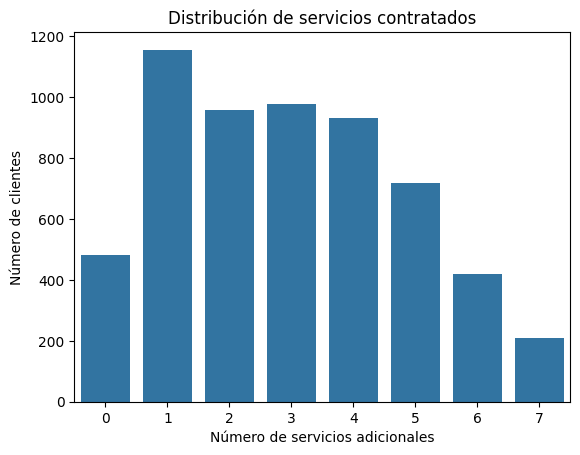

In [226]:

sns.countplot(x='ContratedServices', data=df)
plt.title('Distribución de servicios contratados')
plt.xlabel('Número de servicios adicionales')
plt.ylabel('Número de clientes')
plt.show()

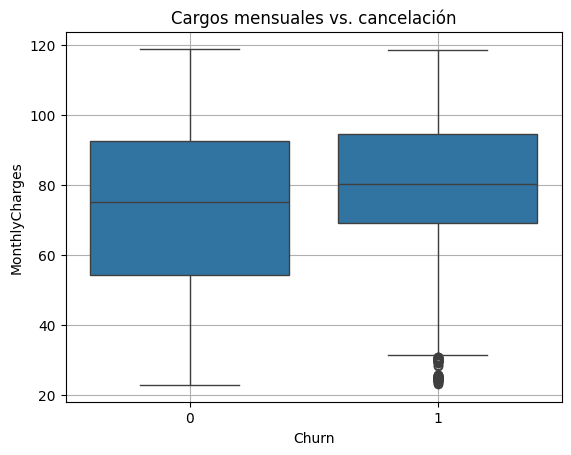

In [227]:
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title('Cargos mensuales vs. cancelación')
plt.grid(True)
plt.show()

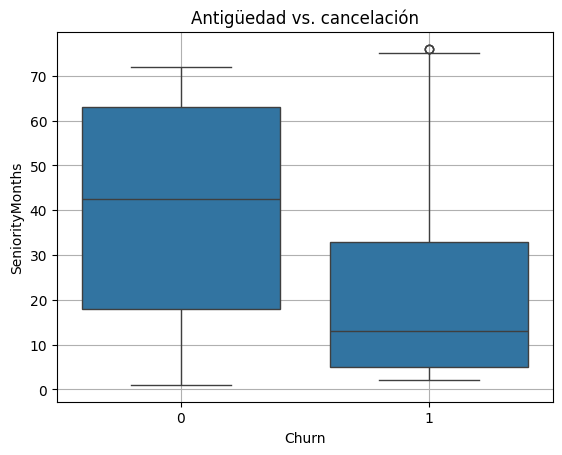

In [228]:
sns.boxplot(x='Churn', y='SeniorityMonths', data=df)
plt.title('Antigüedad vs. cancelación')
plt.grid(True)
plt.show()

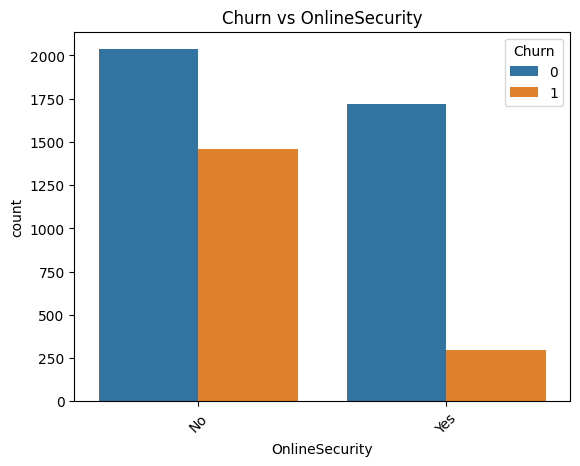

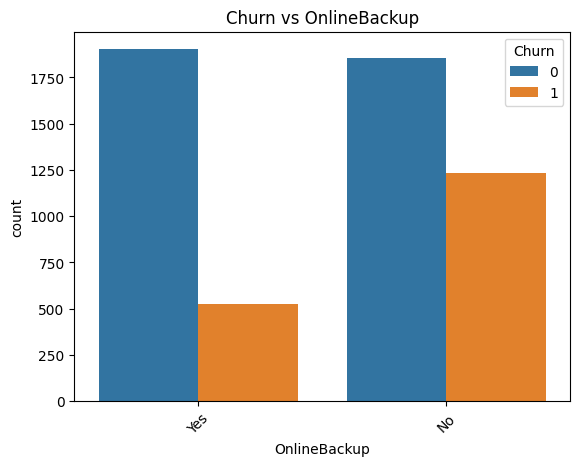

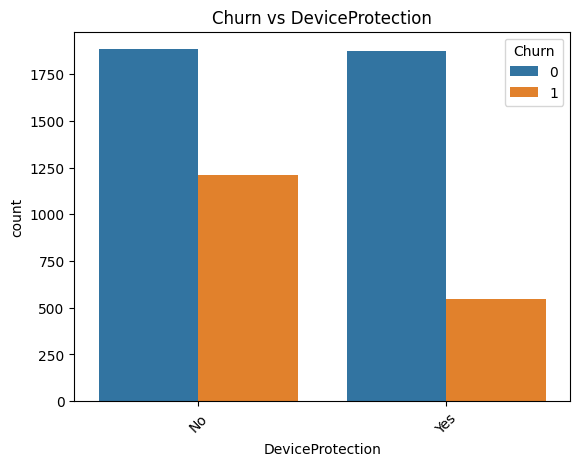

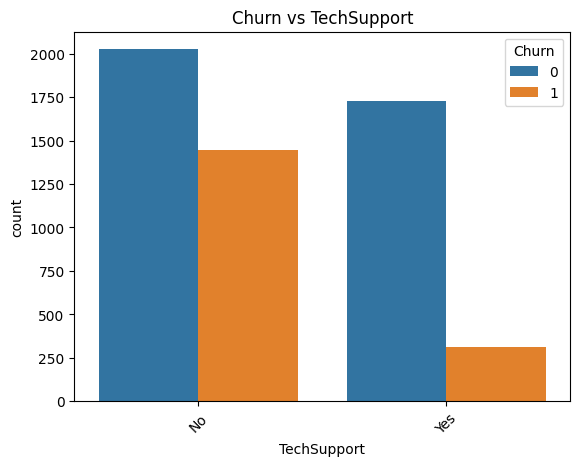

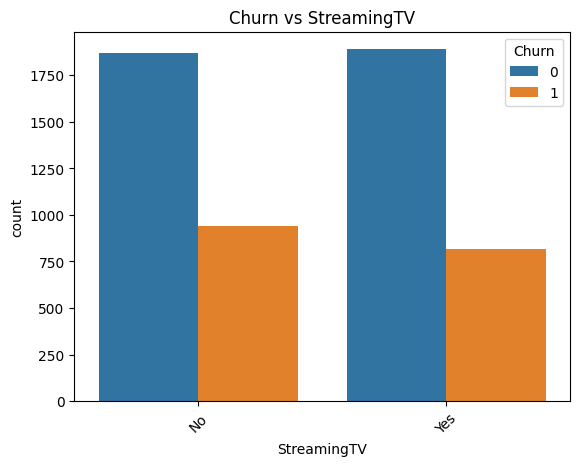

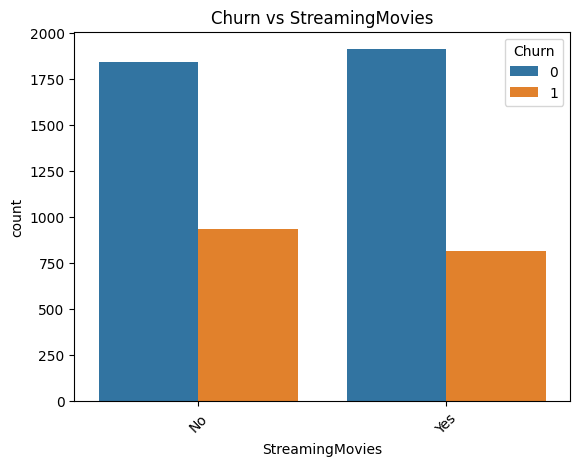

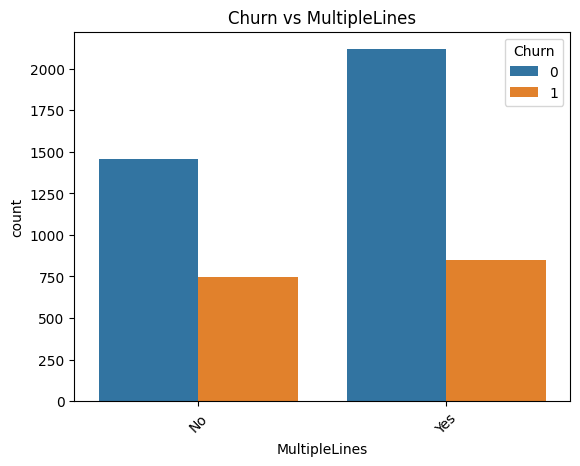

In [229]:
for col in servicios:
    sns.countplot(x=col, hue='Churn', data=df)
    plt.title(f'Churn vs {col}')
    plt.xticks(rotation=45)
    plt.show()